# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Шолохова Татьяна Николаевна

Группа: 317

In [1]:
import numpy as np
import pandas as pd
import sklearn
from collections import defaultdict
import sys

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [2]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
data.shape

(32769, 10)

In [4]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [5]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния (учитите, что он должен возвращать вероятность — отношение объектов первого класса среди соседей к числу соседей). Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba).

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [11]:
def metric0(x, y):
    neq = (x[:, np.newaxis, :] != y[np.newaxis, :, :]).astype('float64')
    return np.sum(neq, axis = 2)

In [12]:
def count_sum_p(x):
    sum_p = list()
    f = list()
    l = x.shape[0]
    for j in range(x.shape[1]):
        f_j = defaultdict(int)
        for i in range(l):
            f_j[x[i, j]] += 1
        f.append(f_j)
        p_j = defaultdict(float)
        for i in f_j:
            p_j[i] = f_j[i] * (f_j[i] - 1) / float(l * (l - 1))
        
        sum_p_j = defaultdict(float)
        for i in p_j:
            for k in p_j:
                if p_j[k] <= p_j[i]:
                    sum_p_j[i] += p_j[k]
        sum_p.append(sum_p_j)
    
    return (f, sum_p)
(f, sum_p) = count_sum_p(X_train)

In [13]:
def metric1(x, y):
    neq = (x[:, np.newaxis, :] != y[np.newaxis, :, :]).astype('float64')
    eq = (x[:, np.newaxis, :] == y[np.newaxis, :, :]).astype('float64')
    for i in range(x.shape[0]):
         for k in range(x.shape[1]):
                eq[i, :, k] *= sum_p[k][x[i][k]]
    return np.sum(neq, axis = 2) + np.sum(eq, axis = 2)

In [14]:
def metric2(x, y):
    neq = (x[:, np.newaxis, :] != y[np.newaxis, :, :]).astype('float64')
    for i in range(x.shape[0]):
        for k in range(x.shape[1]):
            neq[i, :, k] *= np.log(1 + f[k][x[i][k]]) 
    for j in range(y.shape[0]):
        for k in range(y.shape[1]):
            neq[:, j, k] *= np.log(1 + f[k][y[j][k]])
    return np.sum(neq, axis = 2)

In [15]:
def my_knn(X_train, y_train, X_test, metric, k=10):
    dist = metric(X_test, X_train)
    id_sort = np.argsort(dist, axis = 1)
    return np.sum(y_train[id_sort[:, :k]], axis=1) / float(k)

In [14]:
print my_knn(X_train, y_train, X_test[:10], metric0)
print my_knn(X_train, y_train, X_test[:10], metric1)
print my_knn(X_train, y_train, X_test[:10], metric2)

[ 1.   1.   1.   0.9  0.6  1.   0.6  1.   0.9  0.9]
[ 1.   1.   1.   0.9  0.6  1.   0.6  1.   0.9  0.8]
[ 1.   1.   1.   0.9  0.9  1.   0.6  1.   0.9  0.9]


In [16]:
def block_search(X_test, knn, N=100):
    i = 0
    while i < X_test.shape[0]:
        x = X_test[i:min(i + N, X_test.shape[0]),:]
        if (i == 0):
            res = knn(x)
        else:
            new_res = knn(x)
            res = np.concatenate((res, new_res))
        i += N
        sys.stdout.write('.')
        sys.stdout.flush()
    return res

def run_block_knn(X_train, y_train, X_test, metric, k=10, N=100):
    return block_search(X_test, lambda a: my_knn(X_train, y_train, a, metric, k), N)

In [21]:
prob0 = run_block_knn(X_train, y_train, X_test, metric0)
sys.stdout.write('\n')
prob1 = run_block_knn(X_train, y_train, X_test, metric1)
sys.stdout.write('\n')
prob2 = run_block_knn(X_train, y_train, X_test, metric2)

...................................................................................................
...................................................................................................
...................................................................................................

In [24]:
auc0 = sklearn.metrics.roc_auc_score(y_test, prob0)
auc1 = sklearn.metrics.roc_auc_score(y_test, prob1)
auc2 = sklearn.metrics.roc_auc_score(y_test, prob2)
print auc0, auc1, auc2

0.83088009598 0.832873632128 0.820966777872


Лучшей функцией расстояния оказалась metric1 "Индикатор совпадения со штрафом", AUC_ROC = $\bf 83,29\%$

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

In [17]:
CNT_K = 20
def best_k(metric):
    auc = list()
    for k in range(1, CNT_K):
        prob = run_block_knn(X_train, y_train, X_test, metric, k)
        auc.append(sklearn.metrics.roc_auc_score(y_test, prob))
        sys.stdout.write('\n')
        sys.stdout.write(str(auc[-1]) + ' ' + str(k))
        sys.stdout.write('\n')
        sys.stdout.flush()
    return np.array(auc)

In [18]:
auc0 = best_k(metric0)
auc1 = best_k(metric1)
auc2 = best_k(metric2)

...................................................................................................
0.709392461188 1
...................................................................................................
0.777446570068 2
...................................................................................................
0.799401346109 3
...................................................................................................
0.814440745988 4
...................................................................................................
0.822305895749 5
...................................................................................................
0.82708243927 6
...................................................................................................
0.828995914087 7
...................................................................................................
0.830774695372 8
.................................................................

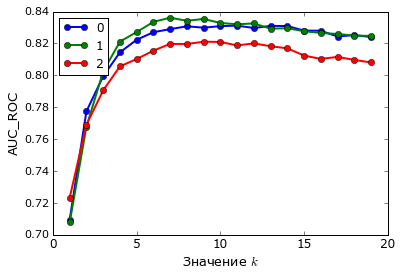

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'verdana'})
rc('text', usetex=False)
rc('text.latex',unicode=True)
rc('text.latex',preamble=u'\\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=u'\\usepackage[russian]{babel}')
rc('xtick', labelsize=12)
plt.plot(np.arange(1, CNT_K), auc0, '-o', label=u'0', linewidth=2)
plt.plot(np.arange(1, CNT_K), auc1, '-o', label=u'1', linewidth=2)
plt.plot(np.arange(1, CNT_K), auc2, '-o', label=u'2', linewidth=2)
plt.xlabel(u"Значение $k$", fontsize=13)
plt.ylabel(u"AUC_ROC", fontsize=13)
plt.yticks(fontsize=11)
plt.legend(loc=2)
plt.show()

Лучшее $k$ для метрики "индикатор совпадения" = $11$, точность = $83,12\%$

Лучшее $k$ для метрики "индикатор совпадения с штрафом" = $7$, точность = $\bf 83,61\%$

Лучшее $k$ для последней метрики = $9$, точность $82,11\%$

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [8]:
def new_features(X_train, y_train, X, block_size=7000):
    res = np.zeros((X.shape[0], X.shape[1]*3))
    for i in range(X_train.shape[1]):
        for j in range(0, X.shape[0], block_size):
            r_border = min(j + block_size, X.shape[0])
            matrix = X[j:r_border, i][:, np.newaxis] == X_train[:, i][np.newaxis, :]
            res[j:r_border, i*3] = np.sum(matrix, axis=1)
            res[j:r_border, i*3 + 1] = np.sum(matrix * y_train[np.newaxis, :], axis = 1)
            res[j:r_border, i*3 + 2] = (res[j:r_border, i*3 + 1] + 1.0) / (res[j:r_border, i*3] + 2)
        sys.stdout.write('.')
        sys.stdout.flush()
    sys.stdout.write('\n')
    return res
def new_features_folding(X_train, n=3):
    l = X_train.shape[0]
    res = np.zeros((X_train.shape[0], X_train.shape[1]*3))
    for i in range(n):
        ins = range(i, l, n)
        outs = np.delete(range(l), ins)
        res[ins, :] = new_features(X_train[outs, :], y_train[outs], X_train[ins, :])
        
    indexes_cc = np.delete(range(res.shape[1]), range(2, res.shape[1], 3))
    res[:, indexes_cc] *= n/(n - 1.0)
    return res

In [23]:
X_train_non_folding = new_features(X_train, y_train, X_train)

.........


In [24]:
X_train_folding = new_features_folding(X_train)

.........
.........
.........


In [25]:
X_test_new = new_features(X_train, y_train, X_test)

.........


In [26]:
CNT_K = 40
auc_folding = []
auc_non_folding = []
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, CNT_K):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_folding, y_train)
    prob = knn.predict_proba(X_test_new)[:, 1]
    auc_folding.append(sklearn.metrics.roc_auc_score(y_test, prob))
    sys.stdout.write('.')
    sys.stdout.flush()
sys.stdout.write('\n')
    
for k in range(1, CNT_K):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_non_folding, y_train)
    prob = knn.predict_proba(X_test_new)[:, 1]
    auc_non_folding.append(sklearn.metrics.roc_auc_score(y_test, prob))
    sys.stdout.write('.')
    sys.stdout.flush()

.......................................
.......................................

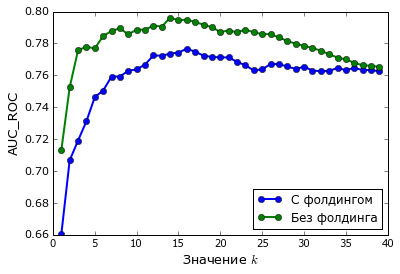

Folding
Best k =  15
Precision =  0.776749110969
Non folding
Best k =  13
Precision =  0.796091066126


In [27]:
auc_folding = np.array(auc_folding)
auc_non_folding = np.array(auc_non_folding)
plt.plot(np.arange(1, CNT_K), auc_folding, '-o', label=u'С фолдингом', linewidth=2)
plt.plot(np.arange(1, CNT_K), auc_non_folding, '-o', label=u'Без фолдинга', linewidth=2)
plt.xlabel(u"Значение $k$", fontsize=13)
plt.ylabel(u"AUC_ROC", fontsize=13)
plt.yticks(fontsize=11)
plt.legend(loc=4)
plt.show()
print "Folding"
print "Best k = ", np.argmax(auc_folding)
print "Precision = ", np.max(auc_folding)
print "Non folding"
print "Best k = ", np.argmax(auc_non_folding)
print "Precision = ", np.max(auc_non_folding)


Лучшее $k$ для алгоритма с фолдами = $15$, точность = $77,67\%$

Лучшее $k$ для алгоритма без фолдов = $13$, точность = $\bf 79,61\%$

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [28]:
def new_pair_features(X):
    l = X.shape[0]
    d = X.shape[1]
    X1 = np.repeat(X, d, axis=1)
    X2 = np.tile(X, [1, d])
    idx = np.array([])
    for i in range(1, d):
        idx = np.concatenate((idx, np.arange(i*d, i*d + i)))
    X1 = np.delete(X1, idx, axis = 1)
    X2 = np.delete(X2, idx, axis = 1)
    return np.core.records.fromarrays([X1, X2], names='a, b')
    

In [29]:
X_train_pair = new_pair_features(X_train)
print X_train_pair.shape[1]

45


In [30]:
X_train_pair_non_folding = new_features(X_train_pair, y_train, X_train_pair)

.............................................


In [31]:
X_train_pair_folding = new_features_folding(X_train_pair)

.............................................
.............................................
.............................................


In [32]:
X_test_pair = new_features(X_train_pair, y_train, new_pair_features(X_test))

.............................................


In [33]:
CNT_K = 40
auc_folding = []
auc_non_folding = []
from sklearn.neighbors import KNeighborsClassifier
for k in range(1, CNT_K):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pair_folding, y_train)
    prob = knn.predict_proba(X_test_pair)[:, 1]
    auc_folding.append(sklearn.metrics.roc_auc_score(y_test, prob))
    sys.stdout.write('.')
    sys.stdout.flush()
sys.stdout.write('\n')
    
for k in range(1, CNT_K):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pair_non_folding, y_train)
    prob = knn.predict_proba(X_test_pair)[:, 1]
    auc_non_folding.append(sklearn.metrics.roc_auc_score(y_test, prob))
    sys.stdout.write('.')
    sys.stdout.flush()

.......................................
.......................................

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'verdana'})
rc('text', usetex=False)
rc('text.latex',unicode=True)
rc('text.latex',preamble=u'\\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=u'\\usepackage[russian]{babel}')

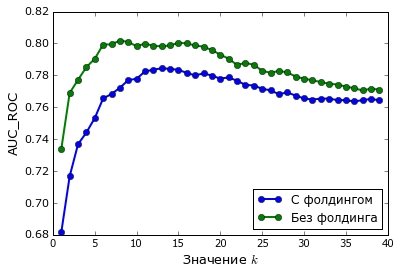

Folding
Best k =  12
Precision =  0.784480825176
Non folding
Best k =  7
Precision =  0.801859076241


In [35]:
auc_folding = np.array(auc_folding)
auc_non_folding = np.array(auc_non_folding)
plt.plot(np.arange(1, CNT_K), auc_folding, '-o', label=u'С фолдингом', linewidth=2)
plt.plot(np.arange(1, CNT_K), auc_non_folding, '-o', label=u'Без фолдинга', linewidth=2)
plt.xlabel(u"Значение $k$", fontsize=13)
plt.ylabel(u"AUC_ROC", fontsize=13)
plt.yticks(fontsize=11)
plt.legend(loc=4)
plt.show()
print "Folding"
print "Best k = ", np.argmax(auc_folding)
print "Precision = ", np.max(auc_folding)
print "Non folding"
print "Best k = ", np.argmax(auc_non_folding)
print "Precision = ", np.max(auc_non_folding)

Лучшее $k$ для алгоритма с фолдами = $12$, точность = $78,45\%$

Лучшее $k$ для алгоритма без фолдов = $7$, точность = $\bf 80,18\%$

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [99]:
X_train2 = X_train_pair_non_folding
X_test2 = X_test_pair
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(random_state=17, max_depth=2, min_samples_leaf=2001)
DTC.fit(X_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=2001,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=17, splitter='best')

In [100]:
prob = DTC.predict_proba(X_test2)[:, 1]
auc = sklearn.metrics.roc_auc_score(y_test, prob)
print auc

0.802384641595


In [89]:
auc = []
for samples_leaf in range(1, 6000, 500):
    auc_i = []
    for depth in range(1, 5, 1):
        DTC = DecisionTreeClassifier(random_state=17, max_depth=depth, min_samples_leaf=samples_leaf)
        DTC.fit(X_train2, y_train)
        prob = DTC.predict_proba(X_test2)[:, 1]
        auc_i.append(sklearn.metrics.roc_auc_score(y_test, prob))
    auc.append(auc_i)
    sys.stdout.write('.')
    sys.stdout.flush()
sys.stdout.write('\n')

............


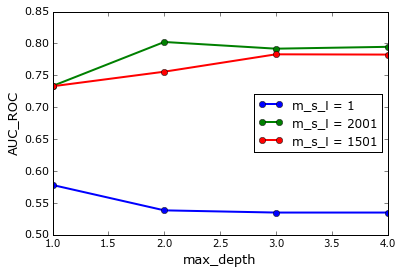

In [95]:
idx = np.argsort(np.max(auc, axis = 1))
for i in range(3):
    plt.plot(np.arange(1, 5, 1), auc[idx[-i]], '-o', label="m_s_l = " + str(idx[-i]*500 + 1), linewidth=2)
plt.xlabel(u"max_depth", fontsize=13)
plt.ylabel(u"AUC_ROC", fontsize=13)
plt.yticks(fontsize=11)
plt.legend(loc=5)
plt.show()

 Наилучший AUC_ROC = $80,24\%$, достигается на парметрах:

$min\_samples\_leaf = 2001$

$max\_depth = 2$

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [140]:
X_train2 = X_train_pair_non_folding
X_test2 = X_test_pair
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=17, max_depth=4, min_samples_leaf=1001, n_estimators=11)
RFC.fit(X_train2, y_train)
prob = RFC.predict_proba(X_test2)[:, 1]
auc_best = sklearn.metrics.roc_auc_score(y_test, prob)
print auc_best

0.834583943453


In [134]:
auc = []
for estimators in range(1, 20, 2):
    auc_j = []
    for samples_leaf in range(1, 6000, 500):
        auc_i = []
        for depth in range(1, 5, 1):
            RFC = RandomForestClassifier(random_state=17, max_depth=depth, min_samples_leaf=samples_leaf, n_estimators=estimators)
            RFC.fit(X_train2, y_train)
            prob = RFC.predict_proba(X_test2)[:, 1]
            auc_i.append(sklearn.metrics.roc_auc_score(y_test, prob))
        auc_j.append(auc_i)
        sys.stdout.write('.')
        sys.stdout.flush()
    auc.append(auc_j)
    sys.stdout.write('\n')

............
............
............
............
............
............
............
............
............
............



In [141]:
idx = np.argwhere(auc == np.max(auc))
print np.max(auc), idx[0][0] * 2 + 1, idx[0][1] * 500 + 1, idx[0][2] + 1

0.834583943453 11 1001 4


Лучший AUC_ROC = $\bf 83,46\%$, достигается на парметрах:

$n\_estimators = 11$

$min\_samples\_leaf = 1001$

$max\_depth = 4$

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [142]:
X_train3 = X_train_pair_folding
X_test3 = X_test_pair

In [167]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=17, max_depth=10, min_samples_leaf=3, n_estimators=270)
RFC.fit(X_train3, y_train)
prob = RFC.predict_proba(X_test3)[:, 1]
auc_best = sklearn.metrics.roc_auc_score(y_test, prob)
print auc_best

0.864658070721


In [170]:
auc = []
for estimators in range(1, 400, 40):
    auc_j = []
    for samples_leaf in range(1, 10, 2):
        auc_i = []
        for depth in range(1, 16, 2):
            RFC = RandomForestClassifier(random_state=17, max_depth=depth, min_samples_leaf=samples_leaf, n_estimators=estimators)
            RFC.fit(X_train3, y_train)
            prob = RFC.predict_proba(X_test3)[:, 1]
            auc_i.append(sklearn.metrics.roc_auc_score(y_test, prob))
        auc_j.append(auc_i)
        sys.stdout.write('.')
        sys.stdout.flush()
    print np.max(auc_j)
    auc.append(auc_j)
    sys.stdout.write('\n')

.....0.804802206278

.....0.867049756995

.....0.869904918408

.....0.868096125355

.....0.866984611691

.....0.866268282917

.....0.866762937947

.....0.867013275624

.....0.866757366901

.....0.866643789433



In [171]:
idx = np.argwhere(auc == np.max(auc))
print np.max(auc), idx[0][0] * 40 + 1, idx[0][1] * 2 + 1, idx[0][2] * 2 + 1

0.869904918408 81 3 13


Лучший AUC_ROC = $\bf 86,99\%$, достигается на парметрах:

$n\_estimators = 81$

$min\_samples\_leaf = 3$

$max\_depth = 13$

Алгоритм $k$ ближайших соседей менее склонен к переобучению, поэтому для него обучение на выборке с фолдингом оказалось менее качественным. 

В случае же с деревьями, которые сильно склонны к переобучению, выборка с фолдингом оказалась лучше, потому что для неё в признаках не учитывается информация о целевой переменной. Это частично решает проблему переобучения древьев.